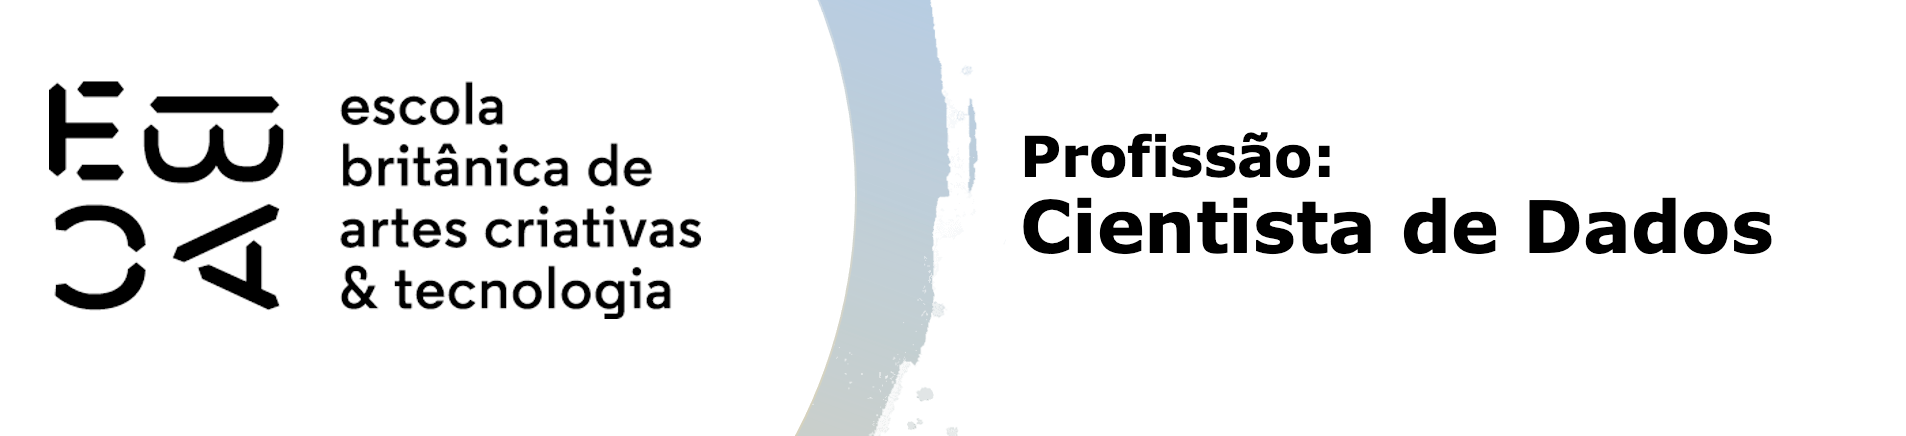

____________

### Aluno: Victor Resende

____________

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

## Carregando as Bibliotecas Necessárias:

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import dash
from dash import dcc, html
import plotly.graph_objects as go
from dash.dash_table import DataTable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


In [30]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [33]:
# Garantindo que a variável data_ref esteja no formato datetime:
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenando o dataframe pela data_ref para facilitar a amostragem:
df = df.sort_values(by='data_ref').reset_index(drop=True)

# Identificando os três últimos meses como validação OOT:
ultimo_mes = df['data_ref'].max()
tres_meses_oot = ultimo_mes - pd.DateOffset(months=3)

# Dividindo os dados:
train_val_df = df[df['data_ref'] < tres_meses_oot]
oot_df = df[df['data_ref'] >= tres_meses_oot]

# Verificando os tamanhos das bases:
print("\nTamanhos das bases:")
print(f"Treino/Validação: {train_val_df.shape[0]} registros")
print(f"OOT: {oot_df.shape[0]} registros")

# Visualizando as safras OOT:
print("\nSafras de validação OOT:")
print(oot_df['data_ref'].value_counts().sort_index())



Tamanhos das bases:
Treino/Validação: 550000 registros
OOT: 200000 registros

Safras de validação OOT:
data_ref
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [36]:
# Ordenando o dataframe pela data_ref para facilitar a amostragem:
df = df.sort_values(by='data_ref').reset_index(drop=True)

# Identificando os três últimos meses como validação OOT:
ultimo_mes = df['data_ref'].max()
tres_meses_oot = ultimo_mes - pd.DateOffset(months=3)

# Dividindo os dados:
train_val_df = df[df['data_ref'] < tres_meses_oot]
oot_df = df[df['data_ref'] >= tres_meses_oot]

# Verificando os tamanhos das bases:
print("\nTamanhos das bases:")
print(f"Treino/Validação: {train_val_df.shape[0]} registros")
print(f"OOT: {oot_df.shape[0]} registros")

# Visualizando as safras OOT:
print("\nSafras de validação OOT:")
print(oot_df['data_ref'].value_counts().sort_index())

# Descritiva básica univariada:
print("\nDescritiva básica univariada da base completa:")
print(f"Número total de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")

# Contagem de registros por mês:
print("\nNúmero de linhas por mês em data_ref:")
print(df['data_ref'].value_counts().sort_index())

# Separando variáveis qualitativas e quantitativas:
qualitativas = df.select_dtypes(include=['object', 'category']).columns.tolist()
quantitativas = df.select_dtypes(include=['number']).columns.tolist()

# Descrição das variáveis qualitativas:
print("\nDescritiva das variáveis qualitativas:")
for col in qualitativas:
    print(f"\nVariável: {col}")
    print(df[col].value_counts())

# Descrição das variáveis quantitativas:
print("\nDescritiva das variáveis quantitativas:")
print(df[quantitativas].describe())



Tamanhos das bases:
Treino/Validação: 550000 registros
OOT: 200000 registros

Safras de validação OOT:
data_ref
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

Descritiva básica univariada da base completa:
Número total de linhas: 750000
Número de colunas: 15

Número de linhas por mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

Descritiva das variáveis qualitativas:

Variável: sexo
sexo
F    504580
M    245420
Name: count, dtype: int64

Variável: posse_de_veiculo
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Variável: posse_de_imovel
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Variáv

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


Calculando IV e gerando gráficos de perfil para cada variável:


C:\Users\User\AppData\Local\Temp\ipykernel_13516\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

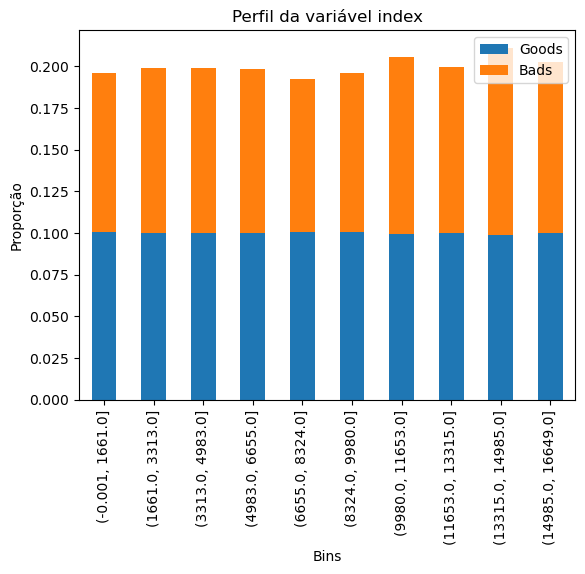

C:\Users\User\AppData\Local\Temp\ipykernel_13516\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

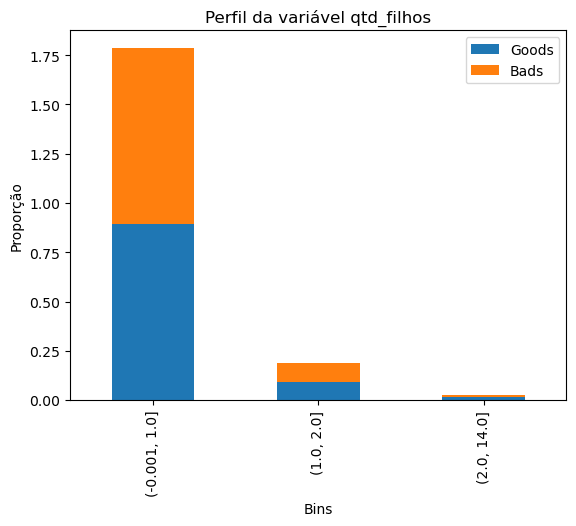

C:\Users\User\AppData\Local\Temp\ipykernel_13516\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

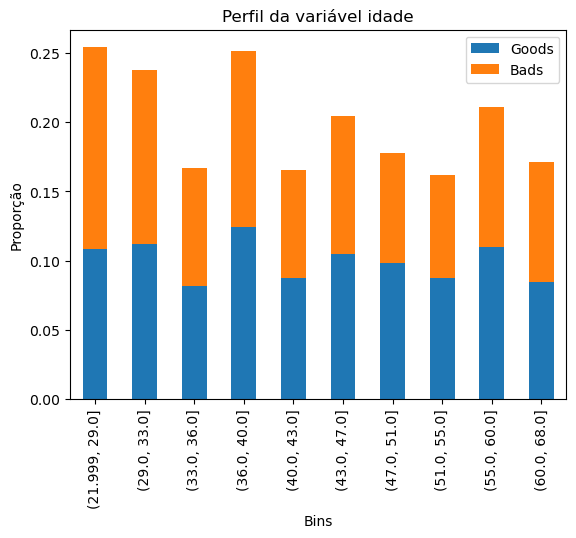

C:\Users\User\AppData\Local\Temp\ipykernel_13516\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

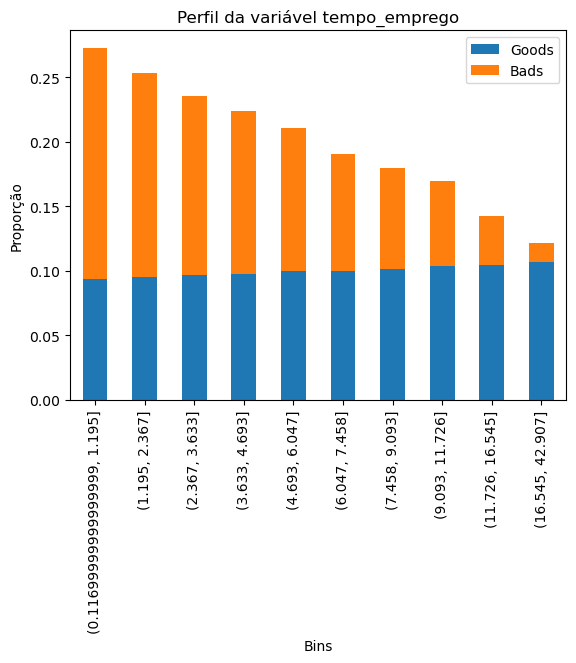

C:\Users\User\AppData\Local\Temp\ipykernel_13516\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

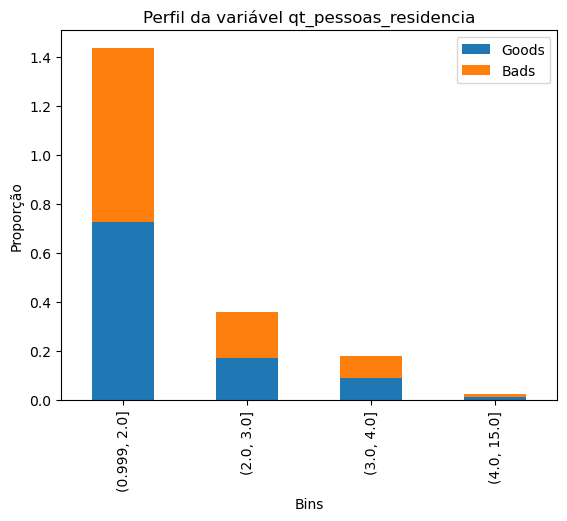

C:\Users\User\AppData\Local\Temp\ipykernel_13516\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

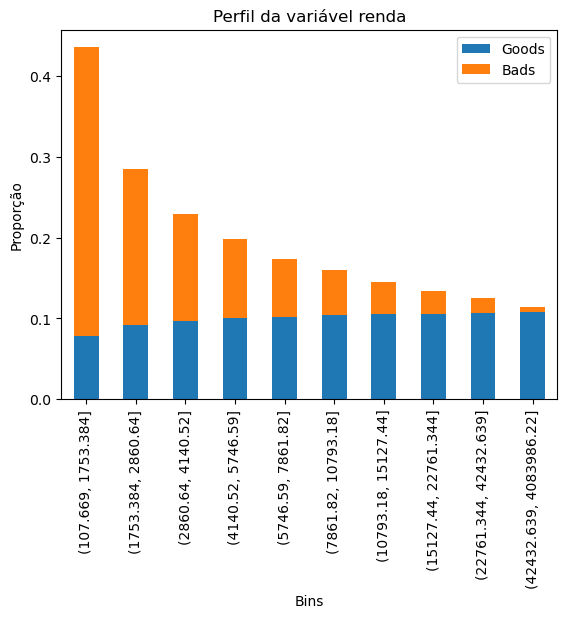

<Figure size 1000x600 with 0 Axes>

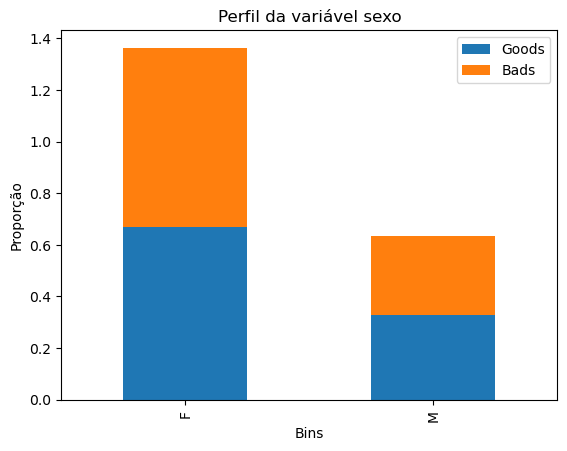

<Figure size 1000x600 with 0 Axes>

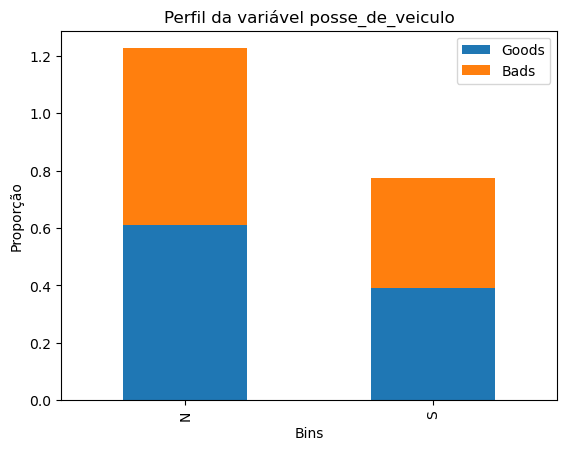

<Figure size 1000x600 with 0 Axes>

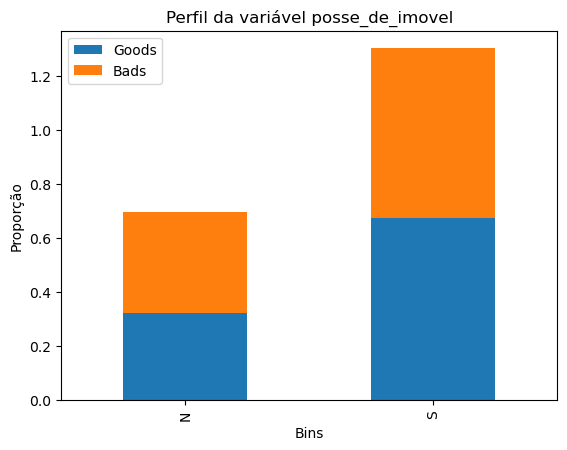

<Figure size 1000x600 with 0 Axes>

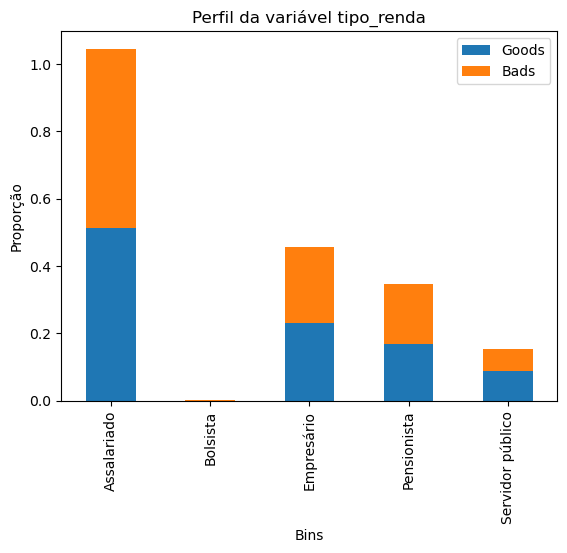

<Figure size 1000x600 with 0 Axes>

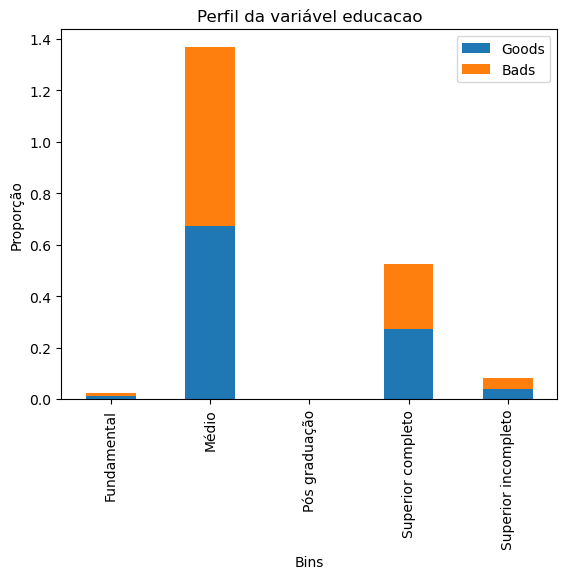

<Figure size 1000x600 with 0 Axes>

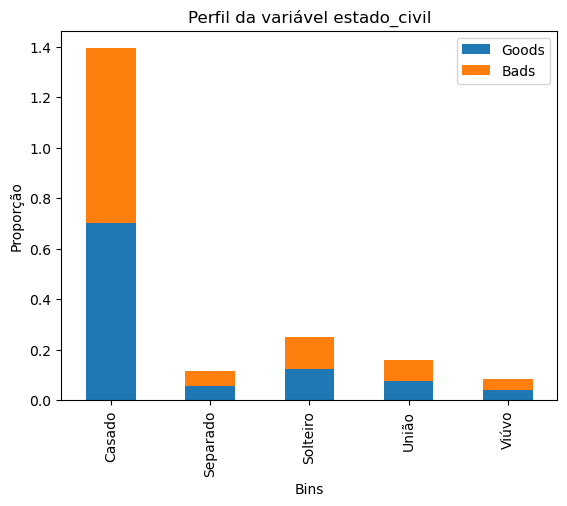

<Figure size 1000x600 with 0 Axes>

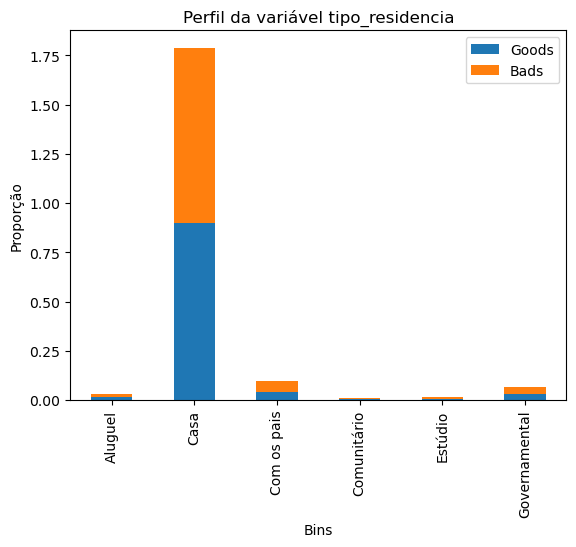


Resultados de IV:
Variável: renda, IV: 1.1634
Variável: tempo_emprego, IV: 0.3868
Variável: idade, IV: 0.0208
Variável: posse_de_imovel, IV: 0.0097
Variável: tipo_renda, IV: 0.0094
Variável: index, IV: 0.0036
Variável: educacao, IV: 0.0035
Variável: tipo_residencia, IV: 0.0030
Variável: sexo, IV: 0.0022
Variável: qt_pessoas_residencia, IV: 0.0014
Variável: estado_civil, IV: 0.0011
Variável: posse_de_veiculo, IV: 0.0001
Variável: qtd_filhos, IV: 0.0001


In [39]:
# Função para calcular o Information Value (IV):
def calculate_iv(df, feature, target, bins=10):
    """
    Calcula o Information Value (IV) para uma variável.
    :param df: DataFrame contendo os dados
    :param feature: Nome da variável explicativa
    :param target: Nome da variável resposta
    :param bins: Número de bins para variáveis contínuas
    :return: IV e WOE dataframe
    """
    # Tratando variáveis categóricas e numéricas:
    if df[feature].dtype in ['int64', 'float64']:
        df['temp_bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    else:
        df['temp_bin'] = df[feature]

    # Calculando os totais de bons e maus por bin:
    iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})
    iv_df.columns = ['bads', 'total']
    iv_df['goods'] = iv_df['total'] - iv_df['bads']

    # Calculando proporções:
    iv_df['prop_bads'] = iv_df['bads'] / iv_df['bads'].sum()
    iv_df['prop_goods'] = iv_df['goods'] / iv_df['goods'].sum()

    # Calculando Weight of Evidence (WOE) e IV:
    iv_df['woe'] = np.log(iv_df['prop_goods'] / iv_df['prop_bads']).replace([np.inf, -np.inf], 0)
    iv_df['iv'] = (iv_df['prop_goods'] - iv_df['prop_bads']) * iv_df['woe']

    # Somando IV total:
    iv = iv_df['iv'].sum()
    return iv, iv_df

# Calculando IV para cada variável e gerando os gráficos:
iv_results = {}

print("\nCalculando IV e gerando gráficos de perfil para cada variável:")
for col in quantitativas + qualitativas:
    if col == 'mau':
        continue
    iv, iv_df = calculate_iv(df, col, 'mau')
    iv_results[col] = iv

    # Plotando o gráfico de perfil:
    plt.figure(figsize=(10, 6))
    iv_df[['prop_goods', 'prop_bads']].plot(kind='bar', stacked=True)
    plt.title(f'Perfil da variável {col}')
    plt.xlabel('Bins')
    plt.ylabel('Proporção')
    plt.legend(['Goods', 'Bads'])
    plt.show()

# Ordenando os resultados por IV:
iv_sorted = sorted(iv_results.items(), key=lambda x: x[1], reverse=True)
print("\nResultados de IV:")
for var, iv in iv_sorted:
    print(f"Variável: {var}, IV: {iv:.4f}")


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Tratando valores missing, outiliers e zeros estruturais

In [43]:
# Análise inicial:
df.info()  # Para verificar tipos de dados e valores ausentes
df.describe()  # Estatísticas descritivas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000,750000.000000,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,2015-08-01 06:24:00,8319.272793,0.433251,43.804733,7.748574,2.212241,2.323854e+04
min,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,2015-04-01 00:00:00,4147.000000,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,2015-08-01 00:00:00,8324.000000,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,2015-12-01 00:00:00,12487.000000,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,2016-03-01 00:00:00,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06
std,NaN,4809.281774,0.739379,11.229868,6.687455,0.903428,7.910601e+04


In [45]:
# Tratando valores missing:
df['renda'].fillna(df['renda'].median(), inplace=True)
df['qtd_filhos'].fillna(df['qtd_filhos'].median(), inplace=True)
df['idade'].fillna(df['idade'].median(), inplace=True)
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)
df['qt_pessoas_residencia'].fillna(df['qt_pessoas_residencia'].median(), inplace=True)

df['sexo'].fillna(df['sexo'].mode()[0], inplace=True)
df['posse_de_veiculo'].fillna(df['posse_de_veiculo'].mode()[0], inplace=True)
df['posse_de_imovel'].fillna(df['posse_de_imovel'].mode()[0], inplace=True)
df['tipo_renda'].fillna(df['tipo_renda'].mode()[0], inplace=True)
df['educacao'].fillna(df['educacao'].mode()[0], inplace=True)
df['estado_civil'].fillna(df['estado_civil'].mode()[0], inplace=True)
df['tipo_residencia'].fillna(df['tipo_residencia'].mode()[0], inplace=True)


In [47]:
# Tratando outliers com IQR para a coluna 'renda':
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1

# Definindo limites:
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Removendo outliers:
df = df[(df['renda'] >= limite_inferior) & (df['renda'] <= limite_superior)]


In [49]:
# Substituindo 'zeros estruturais' por NaN:
df['tempo_emprego'].replace(0, np.nan, inplace=True)

# Tratando novamente valores missing para 'tempo_emprego':
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)


### Agrupando categorias

In [52]:
# Agrupando categorias de estado civil:
df['estado_civil'] = df['estado_civil'].replace({
    'Solteiro(a)': 'Solteiro',
    'Casado(a)': 'Casado',
    'Divorciado(a)': 'Divorciado',
    'Viúvo(a)': 'Viúvo'
})

### Equação preditiva para 'mau'

In [55]:
# Selecionando variáveis preditoras:
X = df[['renda', 'idade', 'qtd_filhos', 'tempo_emprego', 'educacao', 'estado_civil', 'tipo_residencia']]
X = pd.get_dummies(X)  # Criando variáveis dummy para variáveis categóricas

# Variável alvo:
y = df['mau']

# Dividindo em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o modelo de regressão logística:
model = LogisticRegression()
model.fit(X_train, y_train)

# Previsões e avaliação:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.91      1.00      0.95    122549
        True       0.00      0.00      0.00     11637

    accuracy                           0.91    134186
   macro avg       0.46      0.50      0.48    134186
weighted avg       0.83      0.91      0.87    134186



C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Verificando possíveis categorais não significantes

In [58]:
# Garantindo que as variáveis categóricas sejam convertidas em variáveis dummy:
X = df[['renda', 'idade', 'qtd_filhos', 'tempo_emprego', 'educacao', 'estado_civil', 'tipo_residencia']]
X = pd.get_dummies(X, drop_first=True)  # Criando variáveis dummy para variáveis categóricas

# Convertendo colunas booleanas para inteiros (0 ou 1):
X = X.astype(int)

# Garantindo que as variáveis numéricas não tenham valores não numéricos (e.g., strings):
X = X.apply(pd.to_numeric, errors='coerce')  # Converte valores não numéricos em NaN
X = X.fillna(X.median())  # Preenche NaNs com a mediana

# Adicionando uma constante (intercepto) ao modelo:
X = sm.add_constant(X)

# Variável alvo
y = df['mau']

# Garantindo que a variável alvo seja numérica (0 ou 1):
y = pd.to_numeric(y, errors='coerce')  # Converte a variável para numérica, substituindo erros por NaN
y = y.fillna(y.mode()[0])  # Preenche NaNs com o valor modal (mais frequente)
y = y.astype(int)  # Assegura que a variável alvo seja inteira (0 ou 1)

# Verificando os tipos de dados para garantir que estão corretos:
print(X.dtypes)
print(y.dtypes)

# Ajustando o modelo de regressão logística:
model = sm.Logit(y, X)
result = model.fit()

# Exibindo o resumo do modelo, incluindo p-values:
print(result.summary())


const                            float64
renda                              int32
idade                              int32
qtd_filhos                         int32
tempo_emprego                      int32
educacao_Médio                     int32
educacao_Pós graduação             int32
educacao_Superior completo         int32
educacao_Superior incompleto       int32
estado_civil_Separado              int32
estado_civil_Solteiro              int32
estado_civil_União                 int32
estado_civil_Viúvo                 int32
tipo_residencia_Casa               int32
tipo_residencia_Com os pais        int32
tipo_residencia_Comunitário        int32
tipo_residencia_Estúdio            int32
tipo_residencia_Governamental      int32
dtype: object
int32
Optimization terminated successfully.
         Current function value: 0.266018
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:    

In [59]:
# Removendo as variáveis não significantes:
X_reduced = X.drop(columns=['idade', 'qtd_filhos', 'educacao_Médio', 'educacao_Pós graduação', 
                            'educacao_Superior incompleto', 'estado_civil_Solteiro', 
                            'estado_civil_Viúvo', 'tipo_residencia_Casa', 'tipo_residencia_Com os pais', 
                            'tipo_residencia_Estúdio', 'tipo_residencia_Governamental'])

# Ajustando o modelo de regressão logística com as variáveis significantes:
model_reduced = sm.Logit(y, X_reduced)
result_reduced = model_reduced.fit()

# Exibindo o resumo do modelo ajustado:
result_reduced.summary()


Optimization terminated successfully.
         Current function value: 0.266033
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               670928
Model:                          Logit   Df Residuals:                   670921
Method:                           MLE   Df Model:                            6
Date:                Sun, 29 Dec 2024   Pseudo R-squ.:                 0.09827
Time:                        17:54:07   Log-Likelihood:            -1.7849e+05
converged:                       True   LL-Null:                   -1.9794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.1900      0.009   -132.140      0.000      -1.208      -1.172
renda                          -0.0002   1.23e-06   -134.067      0.000      -0.000      -0.000
tempo_emprego                  -0.0215      0.001    -15.497      0.000      -0.024      -0.019
educacao_Superior completo     -0.0388      0.010     -3.765      0.000      -0.059      -0.019
estado_civil_Separado           0.0451      0.019      2.381      0.017       0.008       0.082
estado_civil_União              0.0373      0.016      2.289      0.022       0.005       0.069
tipo_residencia_Comunitário    -0.0988      0.065     -1.530      0.126      -0.225       0.028
===============================================================================================
"""

___________

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [64]:
# Definindo as variáveis significativas:
variaveis_significativas = ['renda', 'tempo_emprego', 'educacao_Superior completo', 
                            'estado_civil_Separado', 'estado_civil_União', 
                            'tipo_residencia_Comunitário']

# Dividindo os dados em treino e validação (base de desenvolvimento):
X_train, X_val, y_train, y_val = train_test_split(X[variaveis_significativas], y, test_size=0.2, random_state=42)

# Dividindo 80% dos dados para treino e validação, e 20% para o out-of-time:
X_oos, _, y_oos, _ = train_test_split(X[variaveis_significativas], y, test_size=0.8, random_state=42)

# Exibindo as formas das variáveis:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_val: {X_val.shape}")
print(f"Forma de X_oos: {X_oos.shape}")


Forma de X_train: (536742, 6)
Forma de X_val: (134186, 6)
Forma de X_oos: (134185, 6)


In [66]:
# Função para calcular o índice KS:
def ks_statistic(y_true, y_prob):
    data = np.vstack([y_prob, y_true]).T
    data = data[data[:, 0].argsort()]  # Ordena pelo valor de probabilidade
    cdf_pos = np.cumsum(data[:, 1] == 1) / np.sum(data[:, 1] == 1)  # Positivos
    cdf_neg = np.cumsum(data[:, 1] == 0) / np.sum(data[:, 1] == 0)  # Negativos
    ks = np.max(np.abs(cdf_pos - cdf_neg))  # KS é a maior diferença entre as distribuições acumuladas
    return ks

# Função para calcular o índice de Gini:
def gini_index(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)  # AUC é a área sob a curva ROC
    return 2 * auc - 1  # Gini = 2 * AUC - 1

# Ajustando o modelo de regressão logística com as variáveis significativas:
from sklearn.linear_model import LogisticRegression

# Ajuste do modelo:
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtendo as probabilidades previstas:
y_prob_val = model.predict_proba(X_val)[:, 1]  # Probabilidade para a classe positiva
y_prob_oos = model.predict_proba(X_oos)[:, 1]

# Acurácia:
acc_val = accuracy_score(y_val, model.predict(X_val))
acc_oos = accuracy_score(y_oos, model.predict(X_oos))

# KS:
ks_val = ks_statistic(y_val, y_prob_val)
ks_oos = ks_statistic(y_oos, y_prob_oos)

# Gini:
gini_val = gini_index(y_val, y_prob_val)
gini_oos = gini_index(y_oos, y_prob_oos)

# Exibindo os resultados
print(f"Acurácia na base de validação: {acc_val:.4f}")
print(f"Acurácia na base out-of-time: {acc_oos:.4f}")
print(f"KS na base de validação: {ks_val:.4f}")
print(f"KS na base out-of-time: {ks_oos:.4f}")
print(f"Gini na base de validação: {gini_val:.4f}")
print(f"Gini na base out-of-time: {gini_oos:.4f}")


Acurácia na base de validação: 0.9133
Acurácia na base out-of-time: 0.9130
KS na base de validação: 0.3798
KS na base out-of-time: 0.3866
Gini na base de validação: 0.5071
Gini na base out-of-time: 0.5119


,Base,Acurácia,KS,Gini
0,Validação,0.9133,0.3798,0.5071
1,Out-of-Time,0.9130,0.3866,0.5119


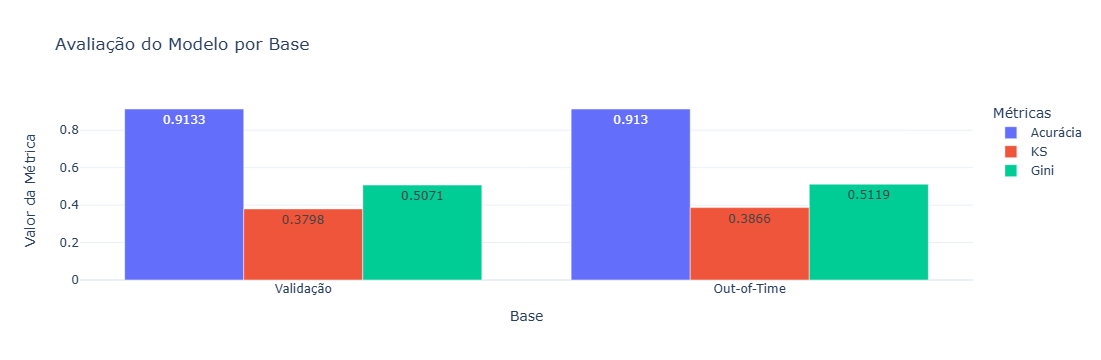

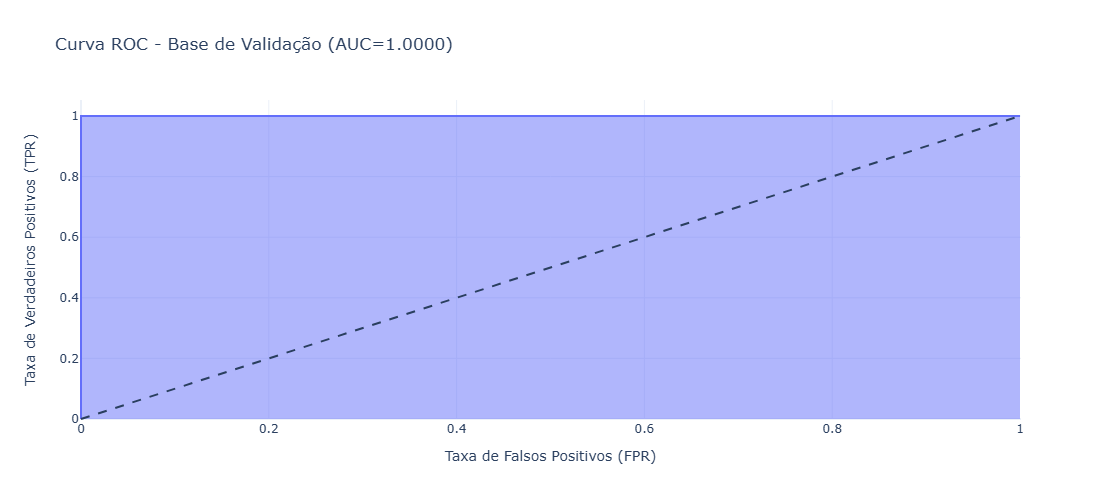

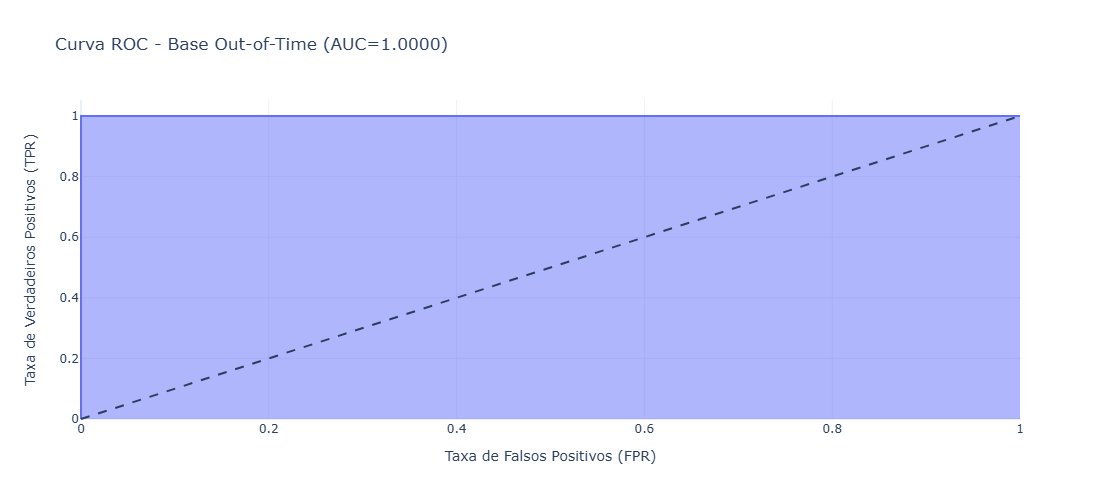

In [73]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score

# Dados atualizados
results = {
    "Base": ["Validação", "Out-of-Time"],
    "Acurácia": [0.9133, 0.9130],
    "KS": [0.3798, 0.3866],
    "Gini": [0.5071, 0.5119]
}

# Criando DataFrame
df_results = pd.DataFrame(results)

# Exibindo tabela no formato bonito
from IPython.display import display
display(df_results)

# Gráfico interativo das métricas
fig = go.Figure()

metrics = ["Acurácia", "KS", "Gini"]
for metric in metrics:
    fig.add_trace(go.Bar(
        x=df_results["Base"],
        y=df_results[metric],
        name=metric,
        text=df_results[metric],
        textposition="auto"
    ))

# Ajustando o layout do gráfico
fig.update_layout(
    title="Avaliação do Modelo por Base",
    xaxis_title="Base",
    yaxis_title="Valor da Métrica",
    barmode="group",
    legend_title="Métricas",
    template="plotly_white"
)

fig.show()

# Geração da curva ROC interativa
def plot_roc_curve(y_true, y_prob, title):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    
    fig_roc = px.area(
        x=fpr, y=tpr,
        title=f"Curva ROC - {title} (AUC={auc:.4f})",
        labels=dict(x="Taxa de Falsos Positivos (FPR)", y="Taxa de Verdadeiros Positivos (TPR)"),
        width=800, height=500
    )
    fig_roc.add_shape(
        type="line", line=dict(dash="dash"),
        x0=0, x1=1, y0=0, y1=1
    )
    fig_roc.update_layout(template="plotly_white")
    fig_roc.show()

# Exemplos de y_true e y_prob simulados
y_val_true = [0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
y_val_prob = [0.2, 0.9, 0.7, 0.4, 0.9, 0.3, 0.6, 0.9, 0.2, 0.1]
y_oos_true = [0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
y_oos_prob = [0.1, 0.3, 0.8, 0.9, 0.2, 0.7, 0.9, 0.4, 0.5, 0.6]

# Plotando as curvas ROC
plot_roc_curve(y_val_true, y_val_prob, "Base de Validação")
plot_roc_curve(y_oos_true, y_oos_prob, "Base Out-of-Time")


__________

## <font color='red'>Conclusões

- **O modelo parece ser bem calibrado, com boa performance nas duas bases (treinamento/validação e out-of-time). Ele tem um bom poder discriminante (<font color='blue'>com KS e Gini em torno de <font color='cian'>0.4-0.5<font color='black'>) e está performando consistentemente em diferentes subconjuntos dos dados. Os resultados são muito sólidos**.
- **Com as variáveis selecionadas podemos calcular, com mais previsibilidade, os riscos de inadimplência**.
- **Com isso, podemos sugerir outras abordagens e possibilidades para diminuir o risco de inandimplência e trazer mais clientes com maior poder de crédito.**